# Accessing the project directory on my Google Drive  

In [1]:
import os
from google.colab import drive

drive.mount('/drive', force_remount=False)
project_dir = "/drive/My Drive/RNNSeq2Seq/"

# change working directory to project_dir
os.chdir(project_dir)

Mounted at /drive


# Dependencies

In [2]:
from scripts.model import *
from scripts.dataloader import create_dataloader
from scripts.utils import *
from scripts.pytorch_utils import *
import matplotlib.pyplot as plt

# Helper function to help visualize 

In [3]:
def plot_log(log):
    len_range = len(log) -1 if "Best eval accu" in log else len(log)
    epoch_nums, train_loss, dev_loss = [], [], []
    train_acc, dev_acc = [], []

    for epoch in range(1, len_range+1):
        epoch_nums.append(epoch)
        train = log[f"Epoch#{epoch}"]["Train"]
        dev = log[f"Epoch#{epoch}"]["Eval"]
        train_loss.append(train['loss'])
        train_acc.append(train['abosulate accuracy'])

        dev_loss.append(dev['loss'])
        dev_acc.append(dev['abosulate accuracy'])

    ax1 = plt.subplot(211)
    ax1.plot(epoch_nums, train_loss, label="train loss")
    ax1.plot(epoch_nums, dev_loss, label="dev loss")
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(epoch_nums, train_acc, label="train acc")
    ax2.plot(epoch_nums, dev_acc, label="dev acc")
    ax2.legend()
    plt.show()

In [4]:
folder = "tuning_data/"
experiment_num = 1
shuffle_batch = False

# must be the num of seq per seq length if shuffle_batch is False
# this "tr_batch_size" will be used for dev, and shuffled test sets
tr_batch_size = 250 
dev_batch_size = 500 if not shuffle_batch else tr_batch_size

In [5]:
# setups for training and evaluting

print_freq = 5
acc_threshold = 0.85 # for saving the best trained models 
max_epoch_num = 100 # max num of epoches 
train_acc_exit=0.9999 # train acc exit threshold (eval_acc_exit must also be met)
eval_acc_exit=0.995 # dev acc exit threshold (train_acc_exit must also be met)
teacher_forcing_ratio = 1.0 # probability of using real symbol from target sequence for training

# RevStr

In [32]:
train = read_data(join(folder, "RevStr/train.txt"))
dev = read_data(join(folder, "RevStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1

- hidden_size = 128
- embd_dim = 64
- learning_rate = 5e-4

In [13]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 128
embd_dim = 64
num_layers = 1
rnn_type = "LSTM"
dropout_rate = 0.0
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 5e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.8801592767238615, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.00750832085032016, 'overlap rate': 0.1538370307534933}
evaluation performance: {'loss': 2.9590022921562196, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.009076544584240764, 'overlap rate': 0.13929352927953004}

Current epoch: 10, 
training performance: {'loss': 2.1989708483219146, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.020874766272027046, 'overlap rate': 0.338623908534646}
evaluation performance: {'loss': 2.79008749127388, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.024515788292046637, 'overlap rate': 0.17174291461706162}

Current epoch: 15, 
training performance: {'loss': 2.251759958267212, 'abosulate accuracy': 0.0011000000522471964, 'consecutive overlap rate': 0.048427685466595, 'overlap rate': 0.4272054512053728}
evaluation performance: {'loss': 2.892501139640808, 'abosulate accuracy': 0.0, 'consecutive overlap rat

In [15]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, 10, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 0.024112703651189803, 'abosulate accuracy': 0.8797000244259834, 'consecutive overlap rate': 0.9812076896429062, 'overlap rate': 0.998857955634594}
evaluation performance: {'loss': 0.05303981613833457, 'abosulate accuracy': 0.8856000378727913, 'consecutive overlap rate': 0.9847909405827522, 'overlap rate': 0.9946961686015129}

Current epoch: 10, 
training performance: {'loss': 0.017944677942432465, 'abosulate accuracy': 0.901500029861927, 'consecutive overlap rate': 0.9900589779019355, 'overlap rate': 0.9993893951177597}
evaluation performance: {'loss': 0.061972831399179994, 'abosulate accuracy': 0.8865500345826149, 'consecutive overlap rate': 0.9880999714136124, 'overlap rate': 0.993615260720253}

/drive/My Drive/RNNSeq2Seq/notebooks/Hyperparatemers Tuning/RevStr_model.pt saved!



## Hyperparameter set 2

- hidden_size = 128
- embd_dim = 64
- learning_rate = 1e-3

In [16]:
hidden_size = 128
embd_dim = 64
num_layers = 1
rnn_type = "LSTM"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 1e-3
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.5143120527267455, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.01486499821767211, 'overlap rate': 0.2676786329597235}
evaluation performance: {'loss': 2.7705169022083282, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.01896495008841157, 'overlap rate': 0.1717205010354519}

Current epoch: 10, 
training performance: {'loss': 1.5869153201580048, 'abosulate accuracy': 0.0015000000596046448, 'consecutive overlap rate': 0.12359610805287957, 'overlap rate': 0.5977980498224497}
evaluation performance: {'loss': 2.5988335698843, 'abosulate accuracy': 0.0016500001191161572, 'consecutive overlap rate': 0.09949018089100718, 'overlap rate': 0.26548359766602514}

Current epoch: 15, 
training performance: {'loss': 0.9347695708274841, 'abosulate accuracy': 0.0025000001420266925, 'consecutive overlap rate': 0.20090362764894962, 'overlap rate': 0.7493706375360489}
evaluation performance: {'loss': 1.7878854662179946, 'abosulate accu

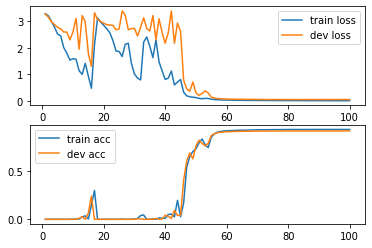

In [18]:
plot_log(log)

# Hyperparameters set 3

In [33]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 128
embd_dim = 64
num_layers = 1
rnn_type = "LSTM"
dropout_rate = 0.2
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.593473654985428, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.01324138870695606, 'overlap rate': 0.22879594713449478}
evaluation performance: {'loss': 2.868892192840576, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.019064656575210392, 'overlap rate': 0.15669048633426427}

Current epoch: 10, 
training performance: {'loss': 2.1580003708601, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.04203450554050505, 'overlap rate': 0.37554027140140533}
evaluation performance: {'loss': 2.9118830800056457, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.08823233200237154, 'overlap rate': 0.19571783766150475}

Current epoch: 15, 
training performance: {'loss': 1.8562999039888382, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.08042014231905341, 'overlap rate': 0.4663070984184742}
evaluation performance: {'loss': 3.0494256794452665, 'abosulate accuracy': 0.004000000254018232, 'consecutive overlap ra

KeyboardInterrupt: ignored

# RedStr



In [21]:
train = read_data(join(folder, "RedStr/train.txt"))
dev = read_data(join(folder, "RedStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1

- hidden_size = 64
- embd_dim = 32
- learning_rate = 5e-3

In [19]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 128
embd_dim = 64
num_layers = 1
rnn_type = "LSTM"
dropout_rate = 0.0
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.279907983541489, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.017914142878726124, 'overlap rate': 0.3292426075786352}
evaluation performance: {'loss': 2.6633397579193114, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.02370794469024986, 'overlap rate': 0.19814589507877828}

Current epoch: 10, 
training performance: {'loss': 1.1048939779400826, 'abosulate accuracy': 0.0034000001614913344, 'consecutive overlap rate': 0.13922024751082063, 'overlap rate': 0.7090708553791046}
evaluation performance: {'loss': 2.520838385820389, 'abosulate accuracy': 0.008550000510876999, 'consecutive overlap rate': 0.10875501772388815, 'overlap rate': 0.33529039323329923}

Current epoch: 15, 
training performance: {'loss': 2.358616289496422, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.07489498788490892, 'overlap rate': 0.36990022137761114}
evaluation performance: {'loss': 2.751055282354355, 'abosulate accuracy': 0.0, 'cons

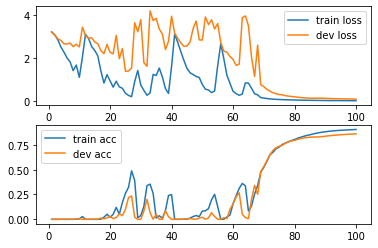

In [23]:
plot_log(log)

## Hyperparameter set 2

- hidden_size = 256
- embd_dim = 128
- learning_rate = 5e-4

In [26]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 128
embd_dim = 64
num_layers = 1
rnn_type = "LSTM"
dropout_rate = 0.0
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 5e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.899112915992737, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.007864064851310104, 'overlap rate': 0.15119578503072262}
evaluation performance: {'loss': 2.965758168697357, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.008974136086180806, 'overlap rate': 0.14180965423583985}

Current epoch: 10, 
training performance: {'loss': 2.0139744102954866, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.021779895259533076, 'overlap rate': 0.39296070486307144}
evaluation performance: {'loss': 3.1246151626110077, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.023052399198058994, 'overlap rate': 0.12816548477858306}

Current epoch: 15, 
training performance: {'loss': 1.9348535925149917, 'abosulate accuracy': 0.0006000000168569386, 'consecutive overlap rate': 0.055288852704688904, 'overlap rate': 0.4774333771318197}
evaluation performance: {'loss': 2.6644691705703734, 'abosulate accuracy': 0.0, 'consecutive ov

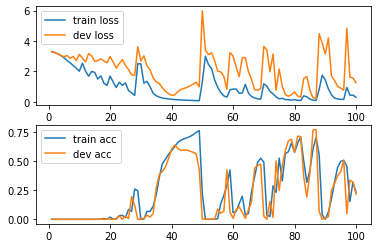

In [28]:
plot_log(log)

# Hyperparameter set 3

In [30]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 128
embd_dim = 64
num_layers = 1
rnn_type = "LSTM"
dropout_rate = 0.2
bidirectional = True
use_attention = True
reduction_method = torch.sum

learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.550019407272339, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.01408919550012797, 'overlap rate': 0.25050279274582865}
evaluation performance: {'loss': 2.8263661205768584, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.023023964115418495, 'overlap rate': 0.17037608548998834}

Current epoch: 10, 
training performance: {'loss': 1.5974395185709, 'abosulate accuracy': 0.0011000000406056643, 'consecutive overlap rate': 0.11510914792306721, 'overlap rate': 0.5591818563640117}
evaluation performance: {'loss': 2.4170556634664537, 'abosulate accuracy': 0.011500000674277543, 'consecutive overlap rate': 0.1716616978868842, 'overlap rate': 0.33773533850908277}

Current epoch: 15, 
training performance: {'loss': 0.9747772432863713, 'abosulate accuracy': 0.029200001840945334, 'consecutive overlap rate': 0.2446237319149077, 'overlap rate': 0.7283202953636646}
evaluation performance: {'loss': 2.65593209117651, 'abosulate accuracy